# Portfolio Optimization Project

### CS/ECE/ISyE 524 — Introduction to Optimization — Fall 2024

### Project Members: Pawin Linmaneechote, Vincent Philavong, Jiajie Yao

## Table of Contents
1. Introduction  
    1.1. Project Motivation  
    1.2. Data Processing  
2. Mathematical Model   
   2.1 Mean Variance Model  
   2.2 Mean Variance Model + Ridge Regression  
   2.3 Sharpe SOCP Model
4. Solution
5. Results and Discussion
6. Conclusion
7. Appendix


# 1. Introduction
## 1.1. Project Motivation
Investing is about making smart decisions to balance the trade-offs between risk and reward. In this project, we explore portfolio optimization by analyzing financial data from Yahoo Finance. We’ve chosen five stocks from key sectors - Technology, Financials, Healthcare, Communication Services, and Industrials - to build a diversified portfolio. This selection spreads risk across industries while aiming to capture each sector’s growth potential. The list of the stock sectors and the individual stocks can be seen below.
- Technology
    - Apple (AAPL)
    - Uber (UBER)
    - Microsoft (MSFT)
    - NVIDIA (NVDA)
    - Advanced Micro Devices (AMD)
- Financial
    - Discover (DFS)
    - JP Morgan (๋JPM)
    - Synchrony (SYF)
    - American Express (AXP)
    - Goldman Sachs (GS)
- Health Care
    - Pfizer (PFE)
    - Johnson & Johnson (JNJ)
    - Merck Sharp & Dohme (MRK)
    - United Health Group (UNH)
    - ABBVie (ABBV)
- Communication Services
    - Meta (META)
    - Google (GOOG)
    - Netflix (NFLX)
    - T-Mobile (TMUS)
    - The Walt Disney Services (DIS)
- Industrials
    - Caterpillar (CAT)
    - RTX Coorporation (RTX)
    - The Boeing Company (BA)
    - Union Pacific Corperation (UNP)
    - Eaton Corporation PLC (ETN)

Our project focuses on optimizing three models. The first serves as our baseline, addressing the challenge of balancing high returns with low risk by analyzing the performance and relationships between the selected stocks. The second builds on the baseline by incorporating Ridge Regularization, which we believe will further enhance diversification within the portfolio. For the third model, we introduce a Sharpe SOCP model, focusing on maximizing returns while minimizing risk more effectively.

Portfolio optimization has been a topic of interest for investors and researchers for decades. It’s rooted in the uncertainty of financial markets, where both short-term gains and long-term stability needed careful evaluation. The economist, Harry Markowitz, revolutionized this field in 1952 with his paper Portfolio Selection, introducing diversification as a way to reduce risk (Team Investopedia, 2023). His work laid the groundwork for modern portfolio theory (MPT) and earned him a Nobel Prize. Yet, as markets continue to evolve, ongoing research is critical to adapting strategies for changing conditions like volatility, economic shifts, and new investor behaviors.

This report is structured into four sections: the Mathematical Model, where we define the decision variables, constraints, and objective function; the Solution, where we implement the model in Julia; Results and Discussion, where we present and interpret the outcomes; and the Conclusion, summarizing our findings and proposing future directions.

In [1]:
using CSV, DataFrames, Dates, Statistics, JuMP, Ipopt, PyPlot, LinearAlgebra

directory_path = "data_files/"

result_df = DataFrame(StockName = String[], OpenStock = Float64[], 
                      CloseStock = Float64[], EquityPercent = Float64[])

stock_sector = CSV.read("Stock Sheet.csv", DataFrame)
rename!(stock_sector, Symbol("Ticker") => :StockName) 

for file in readdir(directory_path)
    if endswith(file, ".csv")
        file_path = joinpath(directory_path, file)
        stock_df = CSV.read(file_path, DataFrame)
        
        stock_df.Date = Date.(string.(stock_df.Date), "yyyy-mm-dd")
        sort!(stock_df, :Date)  
        
        stock_name = splitext(basename(file))[1]
        
        open_price = stock_df.Open[1]
        close_price = stock_df.Close[end]

        equity_percent = ((close_price - open_price) / open_price) * 100

        push!(result_df, (stock_name, open_price, close_price, equity_percent))
    end
end

final_df = leftjoin(result_df, stock_sector[:, [:StockName, :StockSector]], on = :StockName)

select!(final_df, [:StockName, :OpenStock, :CloseStock, :EquityPercent, :StockSector])

println(final_df)

25×5 DataFrame
 Row │ StockName  OpenStock  CloseStock  EquityPercent  StockSector            
     │ String     Float64    Float64     Float64        String31?              
─────┼─────────────────────────────────────────────────────────────────────────
   1 │ AAPL         64.1925      223.45       248.094   Technology
   2 │ UBER         26.06         74.15       184.536   Technology
   3 │ NVDA          5.216       139.91      2582.32    Technology
   4 │ MSFT        144.37        411.46       185.004   Technology
   5 │ AMD          36.06        141.66       292.845   Technology
   6 │ DFS          83.24        151.85        82.4243  Financial
   7 │ JPM         128.69        221.49        72.1113  Financial
   8 │ SYF          36.34         56.82        56.3566  Financial
   9 │ AXP         118.89        275.94       132.097   Financial
  10 │ GS          218.01        526.96       141.714   Financial
  11 │ PFE          35.6831       27.99       -21.5595  Health Care
  12 │ JNJ  

## 1.2 Data Preparation

In [2]:
# Define the directory containing the stock CSV files
directory_path = "data_files/"

# Initialize an empty DataFrame to hold daily returns
returns_df = DataFrame(Date = Date[])

# Read each stock CSV file and compute daily returns
for file in readdir(directory_path)
    if endswith(file, ".csv")
        file_path = joinpath(directory_path, file)
        stock_df = CSV.read(file_path, DataFrame)

        # Ensure the Date column is of Date type
        stock_df.Date = Date.(string.(stock_df.Date), "yyyy-mm-dd")
        sort!(stock_df, :Date)

        stock_name = splitext(basename(file))[1]

        # Calculate daily logarithmic returns
        stock_df[!, :DailyReturn] = [missing; diff(log.(stock_df.Close))]

        # Create a DataFrame with Date and DailyReturn
        stock_returns = stock_df[:, [:Date, :DailyReturn]]
        rename!(stock_returns, :DailyReturn => stock_name)

        # Merge with the returns_df
        if nrow(returns_df) == 0
            returns_df = stock_returns
        else
            returns_df = outerjoin(returns_df, stock_returns, on = :Date)
        end
    end
end

# Remove rows with missing values
complete_cases = dropmissing(returns_df, disallowmissing=true)

# --- Extract Asset Names and Prepare Data ---

# Extract asset names excluding the Date column
# Check the type of column names
col_names = names(complete_cases)
println("Column names:", col_names)
println("Type of column names:", typeof.(col_names))

# Adjust based on the type
if eltype(col_names) == String
    asset_names = setdiff(col_names, ["Date"])
elseif eltype(col_names) == Symbol
    asset_names = setdiff(col_names, [:Date])
else
    error("Unexpected column name types.")
end

# Convert asset_names to strings if necessary
asset_names = string.(asset_names)

# Verify lengths
println("Number of asset names:", length(asset_names))

# Extract the matrix of returns (excluding the Date column)
returns_matrix = Matrix(complete_cases[:, asset_names])

# --- Compute Expected Returns and Covariance Matrix ---

trading_days_per_year = 252  # Number of trading days in a year

# Compute expected daily returns
μ_daily = mean(returns_matrix, dims=1)
μ_daily = vec(μ_daily)  # Convert to a vector

# Annualize expected returns (using compounding)
μ = (1 .+ μ_daily) .^ trading_days_per_year .- 1

# Verify length of μ
println("Length of μ:", length(μ))

# Compute daily covariance matrix
Σ_daily = cov(returns_matrix, dims=1)

# Annualize covariance matrix
Σ = Σ_daily * trading_days_per_year

# Verify size of Σ
println("Size of Σ:", size(Σ))

# Number of assets
n_assets = length(μ)
println("Number of assets (n_assets):", n_assets)



Column names:["Date", "AAPL", "ABBV", "AMD", "AXP", "BA", "CAT", "DFS", "DIS", "ETN", "GOOG", "GS", "JNJ", "JPM", "META", "MRK", "MSFT", "NFLX", "NVDA", "PFE", "RTX", "SYF", "TMUS", "UBER", "UNH", "UNP"]
Type of column names:DataType[String, String, String, String, String, String, String, String, String, String, String, String, String, String, String, String, String, String, String, String, String, String, String, String, String, String]
Number of asset names:25
Length of μ:25
Size of Σ:(25, 25)
Number of assets (n_assets):25


# 2. Mathematical Model

#### Mean Variance Model

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.3.

Number of nonzeros in equality constraint Jacobian...:       25
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      325

Total number of variables............................:       25
                     variables with only lower bounds:       25
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        1
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  4.0664543e-02 7.50e-01 7.42e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

LOCALLY_SOLVED::TerminationStatusCode = 4

The model is feasible.
Portfolio Expected Annual Return: 0.9338886433411973
Portfolio Risk (Annual Standard Deviation): 0.5334712299531479


sys:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


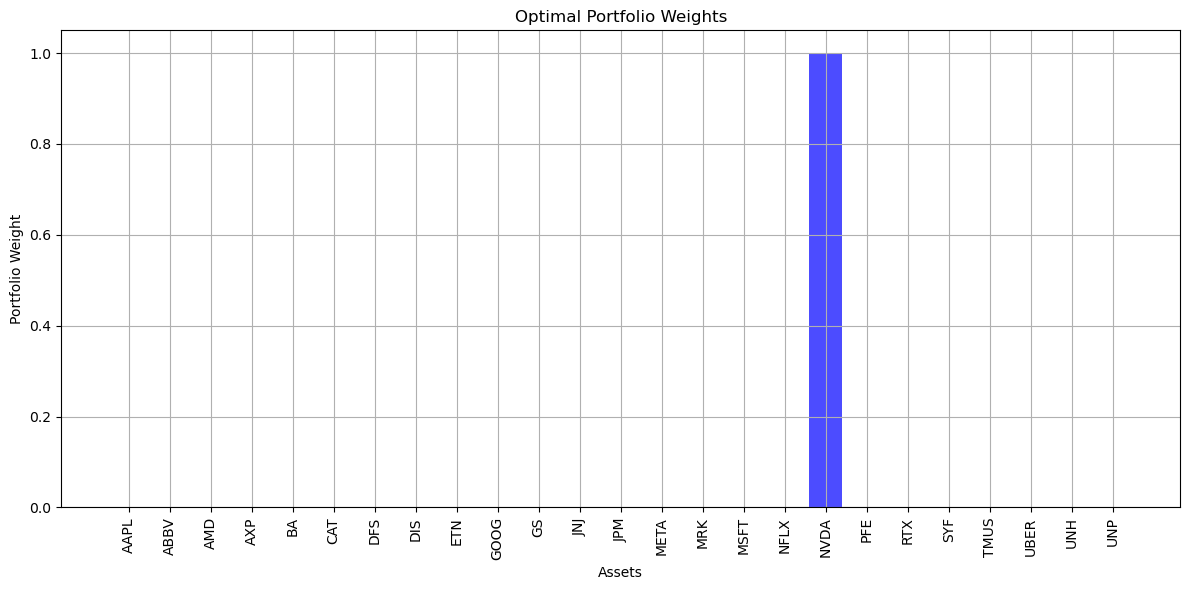

In [16]:
# --- Portfolio Optimization (Mean Varaiance Model)

λ = 1    # Risk aversion parameter

# Create optimization model
m = Model(Ipopt.Optimizer)

@variable(m, x[1:n_assets] >= 0)
@constraint(m, sum(x) == 1)

@objective(m, Max, μ' * x - λ * (x' * Σ * x))

# Solve the model
optimize!(m)

# Check solution status
status = termination_status(m)
display(status)

if status == MOI.OPTIMAL || status == MOI.LOCALLY_SOLVED
    println("The model is feasible.")

    # Extract optimal portfolio weights
    portfolio_weights = value.(x)

    # Compute portfolio return and risk
    portfolio_return = μ' * portfolio_weights  # Annual expected return
    portfolio_risk = sqrt(portfolio_weights' * Σ * portfolio_weights)  # Annual standard deviation

    # --- Plotting ---
    figure(figsize=(12, 6))
    bar(1:n_assets, portfolio_weights, color="blue", alpha=0.7)
    xticks(1:n_assets, asset_names, rotation=90)
    xlabel("Assets")
    ylabel("Portfolio Weight")
    title("Optimal Portfolio Weights")
    grid(true)
    tight_layout()
    show()

    # --- Display Portfolio Metrics ---
    println("Portfolio Expected Annual Return: $portfolio_return")
    println("Portfolio Risk (Annual Standard Deviation): $portfolio_risk")
else
    println("The model is not feasible. Status: $status")
end

#### Mean Variance Model + RIDGE Regression

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.3.

Number of nonzeros in equality constraint Jacobian...:       25
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       25

Total number of variables............................:       25
                     variables with only lower bounds:       25
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        1
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.9272617e-02 7.50e-01 7.57e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

LOCALLY_SOLVED::TerminationStatusCode = 4

The model is feasible.
Portfolio Expected Annual Return: 0.22377326163970995
Portfolio Risk (Annual Standard Deviation): 0.24724399276846304


sys:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


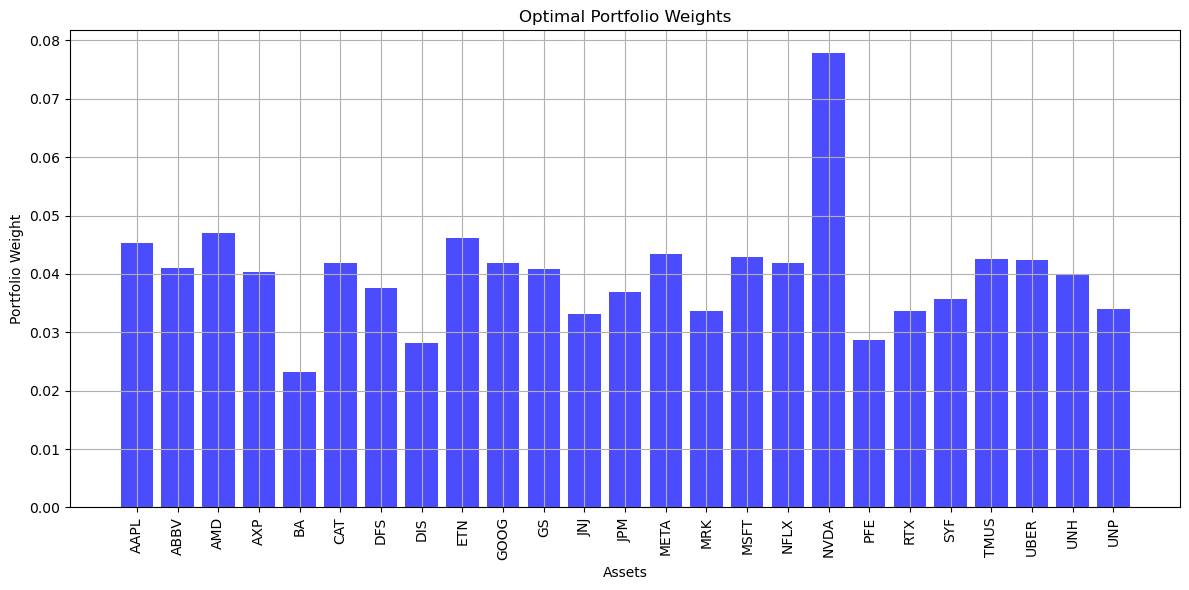

In [4]:
# --- Portfolio Optimization (Mean Varaiance Model + RIDGE Regression)

λ = 0     # Risk aversion parameter
γ = 10        # Diversification parameter

# Create optimization model
m = Model(Ipopt.Optimizer)

@variable(m, x[1:n_assets] >= 0)
@constraint(m, sum(x) == 1)
#@constraint(m, [i in 1:n_assets], x[i] <= 0.15)

@objective(m, Max, μ' * x - λ * (x' * Σ * x) - γ * sum(x[i]^2 for i in 1:n_assets))

# Solve the model
optimize!(m)

# Check solution status
status = termination_status(m)
display(status)

if status == MOI.OPTIMAL || status == MOI.LOCALLY_SOLVED
    println("The model is feasible.")

    # Extract optimal portfolio weights
    portfolio_weights = value.(x)

    # Compute portfolio return and risk
    portfolio_return = μ' * portfolio_weights  # Annual expected return
    portfolio_risk = sqrt(portfolio_weights' * Σ * portfolio_weights)  # Annual standard deviation

    # --- Plotting ---
    figure(figsize=(12, 6))
    bar(1:n_assets, portfolio_weights, color="blue", alpha=0.7)
    xticks(1:n_assets, asset_names, rotation=90)
    xlabel("Assets")
    ylabel("Portfolio Weight")
    title("Optimal Portfolio Weights")
    grid(true)
    tight_layout()
    show()

    # --- Display Portfolio Metrics ---
    println("Portfolio Expected Annual Return: $portfolio_return")
    println("Portfolio Risk (Annual Standard Deviation): $portfolio_risk")
else
    println("The model is not feasible. Status: $status")
end

#### Sharpe Model SOCP

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.3.

Number of nonzeros in equality constraint Jacobian...:       25
Number of nonzeros in inequality constraint Jacobian.:       26
Number of nonzeros in Lagrangian Hessian.............:      376

Total number of variables............................:       26
                     variables with only lower bounds:       26
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        1
Total number of inequality constraints...............:        1
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        1

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.4272542e-04 7.50e-01 1.02e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

LOCALLY_SOLVED::TerminationStatusCode = 4

The model is feasible.
Portfolio Expected Annual Return: 65.86%
Portfolio Risk (Annual Standard Deviation): 36.28%


sys:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


Maximum Sharpe Ratio: 1.7603


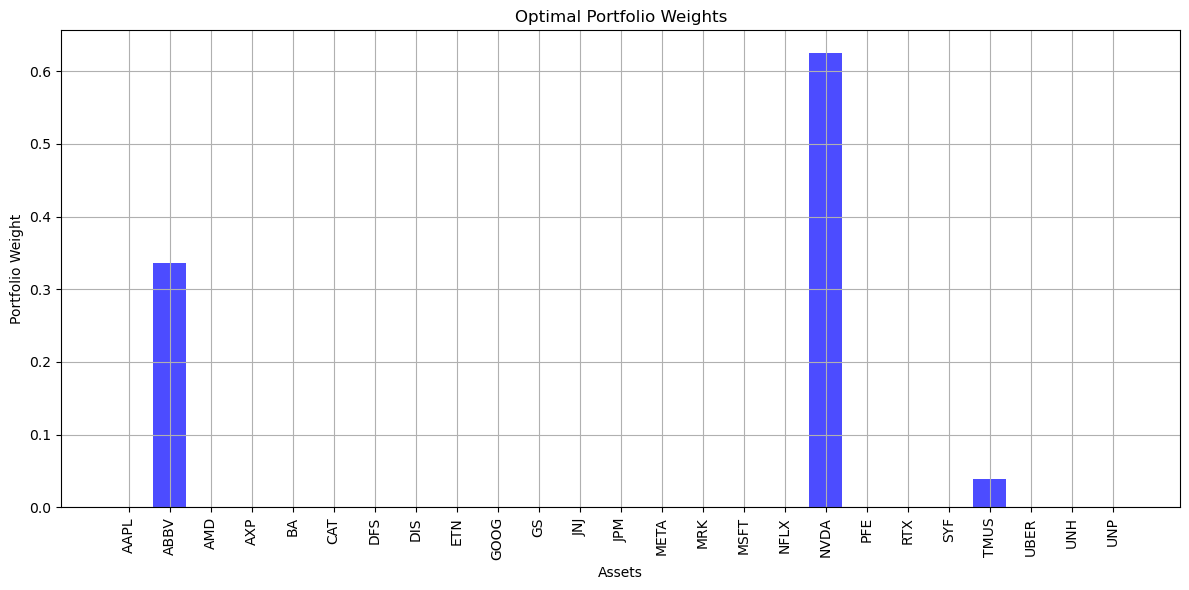

In [5]:
# --- Portfolio Optimization (Sharpe Model SOCP) 

# Define your data
n_assets = length(μ)
r_f = 0.02    # Risk-free rate
R_min = 0.05    # Minimum expected return (if needed)

# Create optimization model
m = Model(Ipopt.Optimizer)

# Define variables
@variable(m, w[1:n_assets] >= 0)   # Portfolio weights (non-negative)
@variable(m, t >= 0)               # Scalar variable t

# Objective function: maximize t * (μ' * w - r_f)
@objective(m, Max, t * (dot(μ, w) - r_f))

#@constraint(m, [i in 1:n_assets], w[i] <= 0.5)

# Constraints
@constraint(m, sum(w) == 1)        # Budget constraint

# Nonlinear constraint: t^2 * w' * Σ * w <= 1
@constraint(m, t^2 * w' * Σ * w  .<= 1)

# Solve the model
optimize!(m)

# Check the termination status
status = termination_status(m)
display(status)

if status == MOI.OPTIMAL || status == MOI.LOCALLY_SOLVED
    println("The model is feasible.")

    # Extract optimal portfolio weights
    portfolio_weights = value.(w)

    # Compute portfolio return and risk
    portfolio_return = dot(μ, portfolio_weights)  # Annual expected return
    portfolio_risk = sqrt(dot(portfolio_weights, Σ * portfolio_weights))  # Annual standard deviation

    # --- Plotting ---
    figure(figsize=(12, 6))

    # Plotting the bar chart
    bar(1:n_assets, portfolio_weights, color="blue", alpha=0.7)

    # Set x-axis labels and rotation
    xticks(1:n_assets, asset_names, rotation=90)

    # Add labels and title
    xlabel("Assets")
    ylabel("Portfolio Weight")
    title("Optimal Portfolio Weights")

    # Add grid and adjust layout
    grid(true)
    tight_layout()

    # Display the plot
    show()

    # --- Display Portfolio Metrics ---
    println("Portfolio Expected Annual Return: $(round(portfolio_return * 100, digits=2))%")
    println("Portfolio Risk (Annual Standard Deviation): $(round(portfolio_risk * 100, digits=2))%")
    println("Maximum Sharpe Ratio: $(round(objective_value(m), digits=4))")
else
    println("The model is not feasible. Status: $status")
end


# 3. Solutions

Sector weights: Dict{Any, Any}(String31("Health Care") => 0.1878135359350184, String31("Technology") => 0.19684312159701706, String31("Communication Services") => 0.22501235488783183, String31("Financial") => 0.1956633768590499, String31("Industrials") => 0.19466761072108268)
Total weight: 1.0


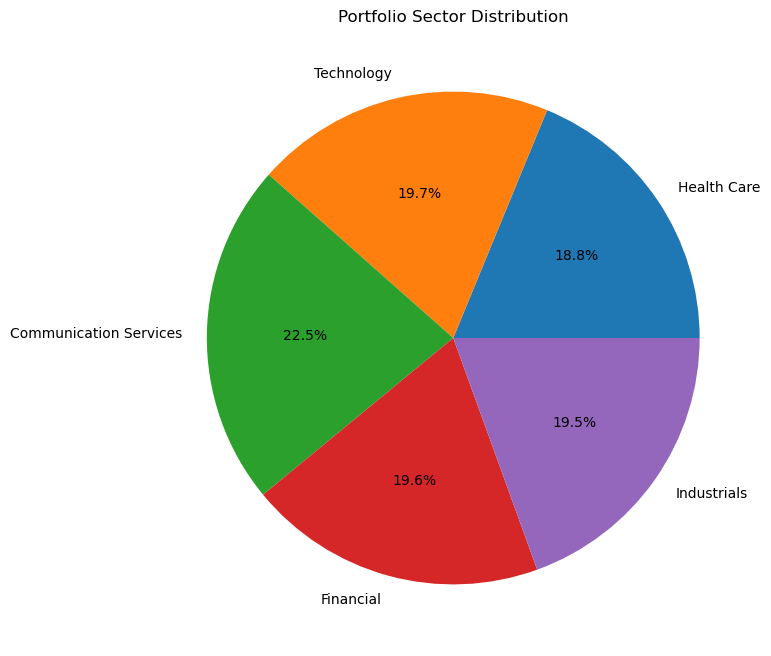

In [6]:
# Calculate total weight for each sector
sector_weights = Dict()
for (i, sector) in enumerate(final_df.StockSector)
    weight = value.(x)[i]
    # Ensure weights are non-negative and handle very small numbers
    weight = max(0, weight)
    if weight > 1e-10  # Only add if weight is significant
        sector_weights[sector] = get(sector_weights, sector, 0) + weight
    end
end

println("Sector weights: ", sector_weights)
println("Total weight: ", sum(values(sector_weights)))

figure(figsize=(10, 8))
pie(collect(values(sector_weights)), 
    labels=collect(keys(sector_weights)),
    autopct="%1.1f%%")
title("Portfolio Sector Distribution")
savefig("sector_allocation.png")

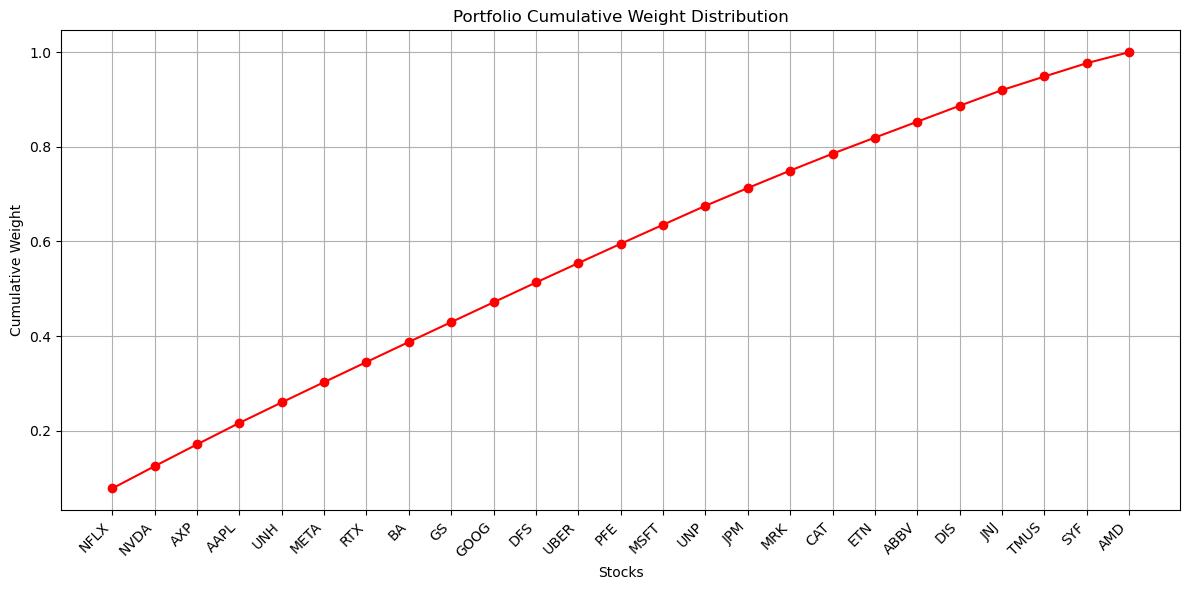

In [7]:
sorted_weights = sort(collect(zip(final_df.StockName, value.(x))), by=x->x[2], rev=true)

# Plot cumulative weights
figure(figsize=(12, 6))
weights = [w[2] for w in sorted_weights]
cumsum_weights = cumsum(weights)
plot(1:length(weights), cumsum_weights, "ro-")  # Changed 'ro-' to "ro-"
xticks(1:length(weights), [w[1] for w in sorted_weights], rotation=45, ha="right")
xlabel("Stocks")
ylabel("Cumulative Weight")
title("Portfolio Cumulative Weight Distribution")
grid(true)
tight_layout()
savefig("cumulative_weights.png")

## Trade-off Analysis Code

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.3.

Number of nonzeros in equality constraint Jacobian...:       25
Number of nonzeros in inequality constraint Jacobian.:       25
Number of nonzeros in Lagrangian Hessian.............:      325

Total number of variables............................:       25
                     variables with only lower bounds:       25
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        1
Total number of inequality constraints...............:        1
        inequality constraints with only lower bounds:        1
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -4.0664543e-02 7.50e-01 9.59e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

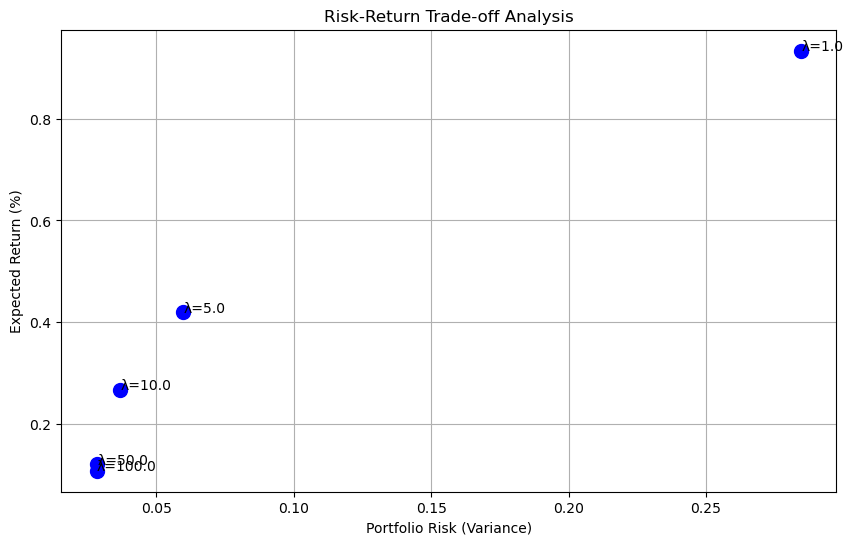

In [8]:
# Calculate risk and return for different λ values
λ_values = [1.0, 5.0, 10.0, 50.0, 100.0]
risk_return_pairs = []

for λ_test in λ_values
    m_test = Model(Ipopt.Optimizer)
    @variable(m_test, x_test[1:25] >= 0)
    @constraint(m_test, sum(x_test) == 1)
    @constraint(m_test, μ'*x_test >= R_min)
    @objective(m_test, Min, -μ'*x_test + λ_test * (x_test'*Σ*x_test))
    optimize!(m_test)
    
    if termination_status(m_test) in [MOI.OPTIMAL, MOI.LOCALLY_SOLVED]
        x_opt = value.(x_test)
        risk = x_opt'*Σ*x_opt
        ret = dot(μ, x_opt)
        push!(risk_return_pairs, (risk, ret, λ_test))
    end
end

# Plot risk-return curve
figure(figsize=(10, 6))
scatter([p[1] for p in risk_return_pairs], 
        [p[2] for p in risk_return_pairs], 
        c="blue", s=100)
for i in 1:length(risk_return_pairs)
    annotate("λ=$(risk_return_pairs[i][3])", 
             (risk_return_pairs[i][1], risk_return_pairs[i][2]))
end
xlabel("Portfolio Risk (Variance)")
ylabel("Expected Return (%)")
title("Risk-Return Trade-off Analysis")
grid(true)
savefig("risk_return_tradeoff.png")

## Sensitivity Analysis Code


Analyzing with γ = 10
λ = 1
This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.3.

Number of nonzeros in equality constraint Jacobian...:       25
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      325

Total number of variables............................:       25
                     variables with only lower bounds:       25
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        1
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.5664593e-02 7.50e-01 7.42e-01  -1.0 0.00

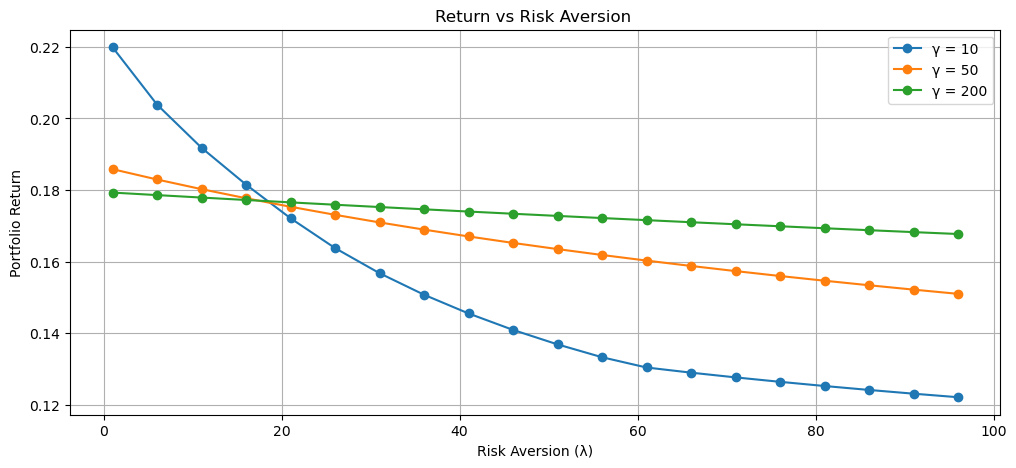

In [9]:
λ_values = 1:5:100
γ_values = [10, 50, 200]  
function optimize_portfolio_ridge_no_Rmin(μ, Σ, λ, γ)
    n = length(μ)
    m = Model(Ipopt.Optimizer)
    
    @variable(m, x[1:n] >= 0)
    
    @constraint(m, sum(x) == 1)
    
    @objective(m, Max, μ' * x - λ * (x' * Σ * x) - γ * sum(x[i]^2 for i in 1:n))
    
    optimize!(m)
    
    return termination_status(m) in [MOI.OPTIMAL, MOI.LOCALLY_SOLVED] ? 
        (value.(x), dot(μ, value.(x)), value.(x)' * Σ * value.(x)) : nothing
end

results = []

for γ in γ_values
    println("\nAnalyzing with γ = $γ")
    for λ in λ_values
        println("λ = $λ")
        result = optimize_portfolio_ridge_no_Rmin(μ, Σ, λ, γ)
        if !isnothing(result)
            push!(results, (λ, γ, result[2], result[3]))
        end
    end
end

println("\nAnalysis Results:")
for (λ, γ, ret, risk) in results
    println("λ = $λ, γ = $γ: Return = $(round(ret, digits=4)), Risk = $(round(risk, digits=4))")
end

using PyPlot

figure(figsize=(12, 5))
for γ in γ_values
    γ_results = filter(r -> r[2] == γ, results)
    plot([r[1] for r in γ_results], 
         [r[3] for r in γ_results], 
         "o-", 
         label="γ = $γ")
end

xlabel("Risk Aversion (λ)")
ylabel("Portfolio Return")
title("Return vs Risk Aversion ")
legend()
grid(true)
savefig("ridge_sensitivity_no_Rmin.png")


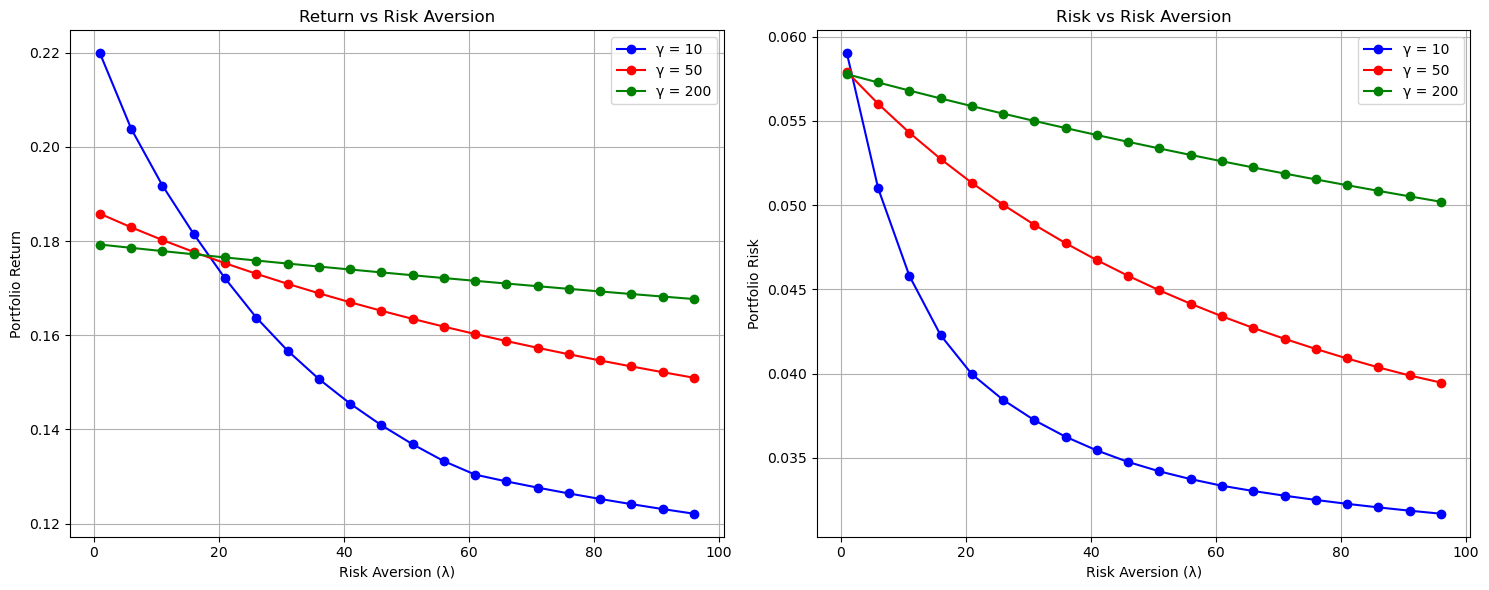

In [10]:
using JuMP, Ipopt, PyPlot, LinearAlgebra

figure(figsize=(15, 6))

colors = ["b", "r", "g", "m", "c"]  

# return plot
subplot(1, 2, 1)
for (i, γ) in enumerate(γ_values)
    γ_results = filter(r -> r[2] == γ, results)
    plot([r[1] for r in γ_results], 
         [r[3] for r in γ_results], 
         "o-", 
         color=colors[i],
         label="γ = $γ")
end
xlabel("Risk Aversion (λ)")
ylabel("Portfolio Return")
title("Return vs Risk Aversion")
legend()
grid(true)

# risk plot
subplot(1, 2, 2)
for (i, γ) in enumerate(γ_values)
    γ_results = filter(r -> r[2] == γ, results)
    plot([r[1] for r in γ_results], 
         [r[4] for r in γ_results], 
         "o-", 
         color=colors[i],
         label="γ = $γ")
end
xlabel("Risk Aversion (λ)")
ylabel("Portfolio Risk")
title("Risk vs Risk Aversion")
legend()
grid(true)

tight_layout()
savefig("risk_return_tradeoff_gamma_lambda.png")


# 4. Results and Discussion

# 5. Conclusion

# 6. Appendix

# 7. References

- Team, T. I. (2023, August 29). Modern portfolio theory: What MPT is and how investors use it. Investopedia. https://www.investopedia.com/terms/m/modernportfoliotheory.asp?utm_source=chatgpt.com 